# cadCAD Tutorials: The Robot and the Marbles, Networks Addition
In [Part 2](https://github.com/BlockScience/SimCAD-Tutorials/blob/master/demos/robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* Policies
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters

In the previous example, we observed how two robotic arms acting in parallel could result in counterintuitive system level behavior despite the simplicity of the individual robotic arm policies. 
In this notebook we'll introduce the concept of networks. This done by extending from two boxes of marbles to *n* boxes which are the nodes in our network. Furthermore, there are are going to be arms between some of the boxes but not others forming a network where the arms are the edges.

__The robot and the marbles__  
* Picture a set of n boxes (`balls`) with an integer number of marbles in each;  a network of robotic arms is capable of taking a marble from their one of their boxes and dropping it into the other one.
* Each robotic arm in the network only controls 2 boxes and they act by moving a marble from one box to the other.
* Each robotic arm is programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.
* For the purposes of our analysis of this system, suppose we are only interested in monitoring the number of marbles in only their two boxes.

In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

T = 25 #iterations in our simulation
n=10 #number of boxes in our network
m= 2 #for barabasi graph type number of edges is (n-2)*m

G = nx.barabasi_albert_graph(n, m)

In [2]:
balls = np.zeros(n,)

for node in G.nodes:
    rv = np.random.randint(1,25)
    G.nodes[node]['initial_balls'] = rv
    balls[node] = rv

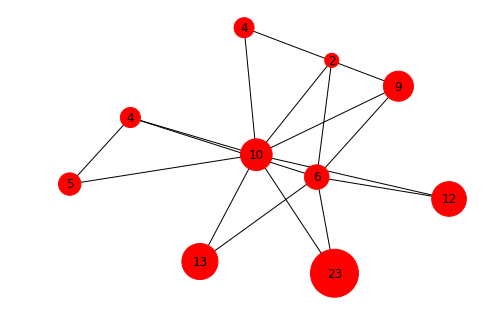

In [3]:
scale=100
nx.draw_kamada_kawai(G, node_size=balls*scale,labels=nx.get_node_attributes(G,'initial_balls'))

In [4]:
initial_conditions = {'balls':balls}

In [5]:
#input the deltas along the edges and update the boxes
#mechanism: edge by node dimensional operator
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)


def update_balls(params, step, sL, s, _input):
    
    delta_balls = _input['delta']
    new_balls = s['balls']
    for e in G.edges:
        move_ball = delta_balls[e]
        src = e[0]
        dst = e[1]
        if new_balls[src] >= move_ball:
            new_balls[src] = new_balls[src]-move_ball
            new_balls[dst] = new_balls[dst]+move_ball
    
    key = 'balls'
    value = new_balls
    
    return (key, value)

In [6]:
#Policy: node by edge dimensional operator
#input the states of the boxes output the deltas along the edges
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robotic networks logic in a Policy Function
# unlike previous examples our policy controls a vector valued action, defined over the edges of our network
def robotic_network(params, step, sL, s):
    
    delta_balls = {}
    for e in G.edges:
        src = e[0]
        dst = e[1]
        #transfer one ball across the edge in the direction of more balls to less
        delta_balls[e] = np.sign(s['balls'][src]-s['balls'][dst])

    return({'delta': delta_balls})

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robotic_network': robotic_network
        },
        'variables': { # The following state variables will be updated simultaneously
            'balls': update_balls,
            
        }
    }
]

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(T),
    'N': 1,
    'M': {}
}

In [9]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [10]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

single_proc: [<cadCAD.configuration.Configuration object at 0x15131d0908>]


In [11]:
balls_list = [b for b in df.balls]

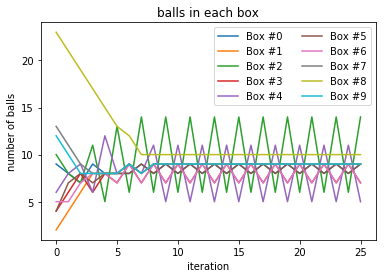

In [12]:
plt.plot(df.timestep.values, balls_list)
plt.xlabel('iteration')
plt.ylabel('number of balls')
plt.title('balls in each box')
plt.legend(['Box #'+str(node) for node in range(n)], ncol = 2)

In [13]:
end_state_balls = np.array([b for b in balls_list[-1]])
avg_balls = np.array([np.mean(b) for b in balls_list])

for node in G.nodes:
    G.nodes[node]['final_balls'] = end_state_balls[node]
    G.nodes[node]['avg_balls'] = avg_balls[node]

[ 9.  9. 14.  7.  5.  9.  7.  9. 10.  9.]


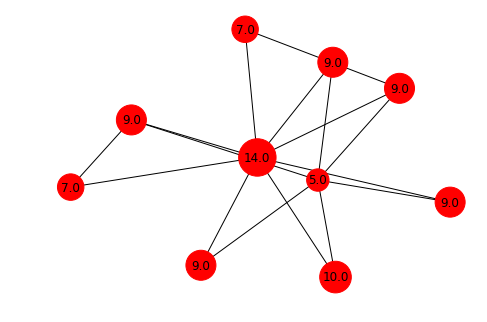

In [14]:
nx.draw_kamada_kawai(G, node_size=end_state_balls*scale, labels=nx.get_node_attributes(G,'final_balls'))
print(end_state_balls)

In [15]:
rolling_avg_balls = np.zeros((len(balls_list), n))
for t in range(T+1):
    for node in G.nodes:
        for tau in simulation_parameters['T'][:t+1]:
            rolling_avg_balls[t,node] = (tau)/(tau+1)*rolling_avg_balls[t, node]+ 1/(tau+1)*balls_list[tau][node]

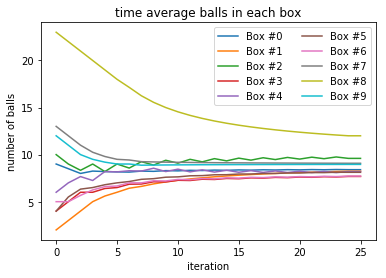

In [16]:
plt.plot(range(len(rolling_avg_balls)),rolling_avg_balls)
plt.xlabel('iteration')
plt.ylabel('number of balls')
plt.title('time average balls in each box')
plt.legend(['Box #'+str(node) for node in range(n)], ncol = 2)

[ 9.  9. 14.  7.  5.  9.  7.  9. 10.  9.]


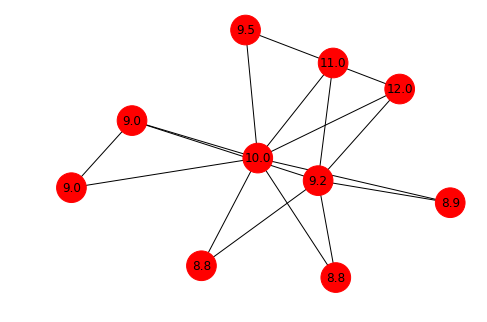

In [17]:
for node in G.nodes:
    G.nodes[node]['avg_balls'] = int(10*(rolling_avg_balls[node][-1]))/10

nx.draw_kamada_kawai(G, node_size=avg_balls*scale, labels=nx.get_node_attributes(G,'avg_balls'))
print(end_state_balls)

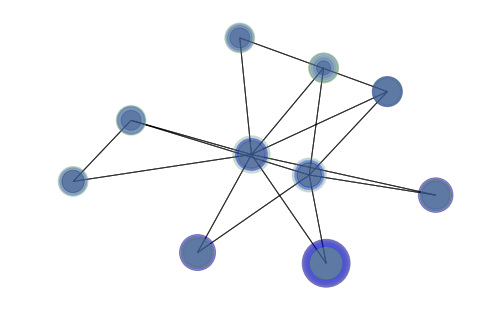

In [18]:
cmap = plt.cm.jet
Nc = cmap.N
Nt = len(simulation_parameters['T'])
dN = int(Nc/Nt)
cmaplist = [cmap(i*dN) for i in range(Nt)]

for t in simulation_parameters['T']:
    state = np.array([b for b in balls_list[t]])
    nx.draw_kamada_kawai(G, node_size=state*scale, alpha = .4/(t+1), node_color = cmaplist[t])